Train samples: 23017
Validation samples: 2877
Test samples: 2878
Example record:
{'instruction': 'extract aspect term-opinion term pairs from the sentence', 'input': "Heck , I like all Mac computers , but they 're all WAY too pricey for the kind of economy the U.S. is going through .", 'output': 'there are no aspect term-opinion term pairs in the sentence.', 'text': "extract aspect term-opinion term pairs from the sentence <NAME> , I like all <NAME> computers , but they 're all WAY too pricey for the kind of economy the U.S. is going through .", 'label': 1, 'input_ids': [0, 16435, 15664, 6659, 1385, 12, 1517, 31210, 1385, 15029, 31, 5, 3645, 28696, 48307, 15698, 2156, 38, 101, 70, 28696, 48307, 15698, 7796, 2156, 53, 51, 128, 241, 70, 26727, 350, 26428, 13, 5, 761, 9, 866, 5, 121, 4, 104, 4, 16, 164, 149, 479, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

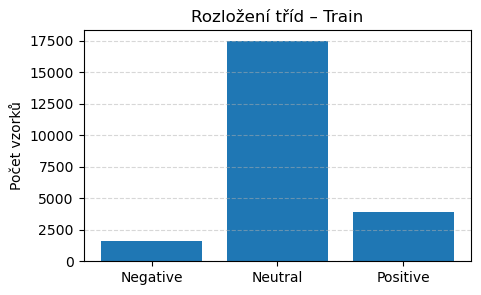


Validation - Statistika tříd:
  Negative:   206 ( 7.16%)
  Neutral :  2180 (75.77%)
  Positive:   491 (17.07%)


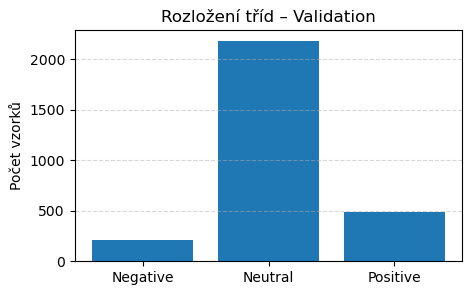


Test - Statistika tříd:
  Negative:   206 ( 7.16%)
  Neutral :  2181 (75.78%)
  Positive:   491 (17.06%)


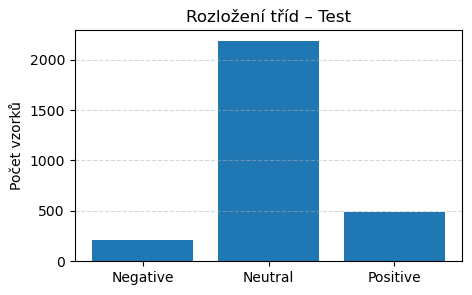


Vypočítané váhy tříd:
  Negative: 4.6584
  Neutral : 0.4399
  Positive: 1.9537


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: --load_best_model_at_end requires the save and eval strategy to match, but found
- Evaluation strategy: IntervalStrategy.NO
- Save strategy: SaveStrategy.EPOCH

In [4]:
from datasets import load_dataset
import re
from transformers import RobertaTokenizer
import pandas as pd
import matplotlib.pyplot as plt

# ============================================
# 1️ Načtení datasetu
# ============================================
ds = load_dataset("yuncongli/chat-sentiment-analysis", split="train")


# ============================================
# 2️ Maskování citlivých údajů
# ============================================
def mask_sensitive(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", "<EMAIL>", text)
    text = re.sub(r"http\S+|www\.\S+", "<URL>", text)
    text = re.sub(r"\+?\d[\d\-\s]{7,}\d", "<PHONE>", text)
    text = re.sub(r"@[A-Za-z0-9_]+", "<USER>", text)
    text = re.sub(r"\b\d{4,}\b", "<NUMBER>", text)
    text = re.sub(r"(?<![.!?]\s)(?<!^)(\b[A-Z][a-z]+)", "<NAME>", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


# ============================================
# 3️ Extrakce sentimentu z pole output
# ============================================
def extract_sentiment(output_text: str):
    """
    0 -> Negative
    1 -> Neutral
    2 -> Positive
    """
    if not isinstance(output_text, str):
        return 1

    output_text = output_text.lower()
    has_pos = "positive" in output_text
    has_neg = "negative" in output_text

    if has_pos and not has_neg:
        return 2
    elif has_neg and not has_pos:
        return 0
    else:
        return 1


# ============================================
# 4️ Transformace dat
# ============================================
def transform(example):
    text = ((example.get("instruction") or "") + " " + (example.get("input") or "")).strip()
    text = mask_sensitive(text)
    label = extract_sentiment(example.get("output", ""))
    return {"text": text, "label": label}


clean_ds = ds.map(transform)
clean_ds = clean_ds.filter(lambda x: len(x["text"]) > 5)


# ============================================
# 5️ Tokenizace
# ============================================
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

from datasets import ClassLabel
new_features = clean_ds.features.copy()
new_features["label"] = ClassLabel(names=["Negative", "Neutral", "Positive"])
clean_ds = clean_ds.cast(new_features)
tokenized_ds = clean_ds.map(tokenize, batched=True)


# ============================================
# 6️ Rozdělení datasetu
# ============================================
split_ds = tokenized_ds.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)
train_ds = split_ds["train"]
testval = split_ds["test"].train_test_split(test_size=0.5, stratify_by_column="label", seed=42)
valid_ds = testval["train"]
test_ds = testval["test"]

print(f"Train samples: {len(train_ds)}")
print(f"Validation samples: {len(valid_ds)}")
print(f"Test samples: {len(test_ds)}")
print("Example record:")
print(train_ds[0])


# ============================================
# 7️ Statistika tříd
# ============================================
def show_label_stats(dataset, name="Dataset"):
    labels = list(dataset["label"])
    df = pd.DataFrame({"label": labels})
    counts = df["label"].value_counts().sort_index()
    total = counts.sum()
    label_names = ["Negative", "Neutral", "Positive"]
    print(f"\n{name} - Statistika tříd:")
    for i, count in counts.items():
        perc = (count / total) * 100
        print(f"  {label_names[i]:<8}: {count:5d} ({perc:5.2f}%)")

    plt.figure(figsize=(5,3))
    plt.bar(label_names, counts)
    plt.title(f"Rozložení tříd – {name}")
    plt.ylabel("Počet vzorků")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()

show_label_stats(train_ds, "Train")
show_label_stats(valid_ds, "Validation")
show_label_stats(test_ds, "Test")


# ============================================
# 8️ Výpočet vah tříd
# ============================================
import torch
from collections import Counter

def compute_class_weights(dataset):
    labels = list(dataset["label"])
    counter = Counter(labels)
    total = sum(counter.values())
    num_classes = len(counter)
    weights = [total / (num_classes * counter[i]) for i in range(num_classes)]
    class_weights = torch.tensor(weights, dtype=torch.float)
    print("\nVypočítané váhy tříd:")
    for i, w in enumerate(weights):
        label_name = ["Negative", "Neutral", "Positive"][i]
        print(f"  {label_name:<8}: {w:.4f}")
    return class_weights

class_weights = compute_class_weights(train_ds)


# ============================================
# 9️ Trénování modelu
# ============================================
from transformers import (
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
import torch.nn as nn
import inspect

model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Weighted Trainer
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels").to(device)
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


data_collator = DataCollatorWithPadding(tokenizer)

# Dynamická kompatibilita pro různé verze transformers
common_args = dict(
    output_dir="./roberta-sentiment_v3",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.05,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    seed=42,
    logging_steps=100,
)

sig = inspect.signature(TrainingArguments.__init__)
init_params = sig.parameters

if "evaluation_strategy" in init_params:
    common_args["evaluation_strategy"] = "epoch"
else:
    common_args["eval_steps"] = max(1, len(train_ds) // max(1, common_args["per_device_train_batch_size"]))

if "save_strategy" in init_params:
    common_args["save_strategy"] = "epoch"
else:
    common_args["save_steps"] = max(1, len(train_ds) // max(1, common_args["per_device_train_batch_size"]))

training_args = TrainingArguments(**common_args)


from transformers import TrainingArguments

# ============================================
# 10 Nastavení tréninku
# ============================================

common_args = {
    "output_dir": "./results",                       # kam se ukládají modely
    "overwrite_output_dir": True,
    "num_train_epochs": 3,                           # počet epoch
    "per_device_train_batch_size": 8,                # velikost batch
    "per_device_eval_batch_size": 8,
    "learning_rate": 2e-5,
    "weight_decay": 0.01,
    "evaluation_strategy": "epoch",                  # vyhodnocuje po každé epoše
    "save_strategy": "epoch",                        # ukládá po každé epoše
    "load_best_model_at_end": True,                  # načte nejlepší model po tréninku
    "metric_for_best_model": "f1",                   # podle čeho hodnotí „nejlepší“ model
    "greater_is_better": True,
    "logging_dir": "./logs",
    "logging_strategy": "epoch",
    "save_total_limit": 2,                           # kolik modelů maximálně uchovat
    "fp16": False,                                   # můžeš dát True na GPU s podporou FP16
    "seed": 42,
}

training_args = TrainingArguments(**common_args)


# ============================================
# 1️1️ Spuštění tréninku
# ============================================
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


# ============================================
# 1️2️ Uložení modelu a tokenizeru
# ============================================
model.config.id2label = {0: "Negative", 1: "Neutral", 2: "Positive"}
model.config.label2id = {"Negative": 0, "Neutral": 1, "Positive": 2}

best_output_dir = "./roberta-sentiment_v3"
trainer.save_model(best_output_dir)
tokenizer.save_pretrained(best_output_dir)
print(f"\n✅ Model a tokenizer uloženy do: {best_output_dir}")


# ============================================
# 1️3️ Vyhodnocení na testovací sadě
# ============================================
metrics = trainer.evaluate(test_ds)
print("\n📊 Výsledky na testovacích datech:")
for k, v in metrics.items():
    print(f"{k:<12}: {v:.4f}")


# ============================================
# 1️4️ Inference (pipeline ukázka)
# ============================================
from transformers import pipeline

device = 0 if torch.cuda.is_available() else -1
pipe = pipeline("text-classification", model=best_output_dir, tokenizer=best_output_dir, return_all_scores=True, device=device)

samples = [
    "I am so happy today! Everything went perfectly.",
    "I feel so sad and disappointed.",
    "It's just an ordinary day, nothing special happened."
]

print("\n Ukázka predikce:")
for t in samples:
    out = pipe(t)[0]
    print("Text:", t)
    for cls in out:
        print(f"  {cls['label']}: {cls['score']:.4f}")
    print()


Map:   0%|          | 0/28772 [00:00<?, ? examples/s]

Filter:   0%|          | 0/28772 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/28772 [00:00<?, ? examples/s]

Map:   0%|          | 0/28772 [00:00<?, ? examples/s]

Train samples: 23017
Validation samples: 2877
Test samples: 2878
Example record:
{'instruction': 'extract aspect term-opinion term pairs from the sentence', 'input': "Heck , I like all Mac computers , but they 're all WAY too pricey for the kind of economy the U.S. is going through .", 'output': 'there are no aspect term-opinion term pairs in the sentence.', 'text': "extract aspect term-opinion term pairs from the sentence <NAME> , I like all <NAME> computers , but they 're all WAY too pricey for the kind of economy the U.S. is going through .", 'label': 1, 'input_ids': [0, 16435, 15664, 6659, 1385, 12, 1517, 31210, 1385, 15029, 31, 5, 3645, 28696, 48307, 15698, 2156, 38, 101, 70, 28696, 48307, 15698, 7796, 2156, 53, 51, 128, 241, 70, 26727, 350, 26428, 13, 5, 761, 9, 866, 5, 121, 4, 104, 4, 16, 164, 149, 479, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

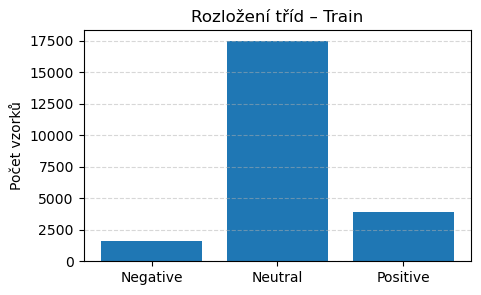


Validation - Statistika tříd:
  Negative:   206 ( 7.16%)
  Neutral :  2180 (75.77%)
  Positive:   491 (17.07%)


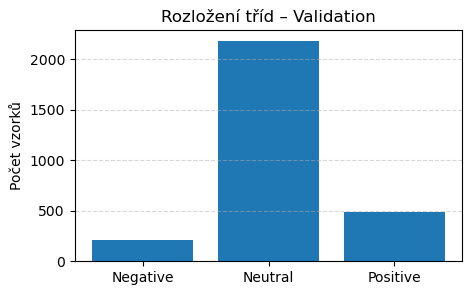


Test - Statistika tříd:
  Negative:   206 ( 7.16%)
  Neutral :  2181 (75.78%)
  Positive:   491 (17.06%)


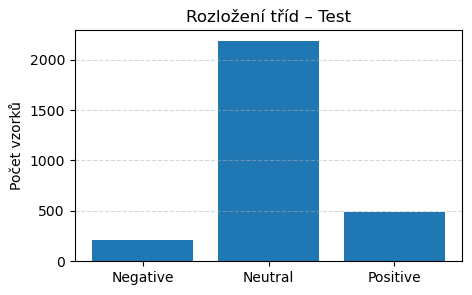

Počet vzorků v třídách: Counter({1: 17443, 2: 3927, 0: 1647})
Vypočítané (normalizované) váhy tříd:
  Negative: 1.9817
  Neutral : 0.1871
  Positive: 0.8311


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [5]:
# ============================================
# test, zda je opravený skript
# ============================================

from datasets import load_dataset, ClassLabel
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from collections import Counter

from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    pipeline
)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# ============================================
# 1️ Načtení datasetu
# ============================================
ds = load_dataset("yuncongli/chat-sentiment-analysis", split="train")

# ============================================
# 2️ Maskování citlivých údajů
# ============================================
def mask_sensitive(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", "<EMAIL>", text)
    text = re.sub(r"http\S+|www\.\S+", "<URL>", text)
    text = re.sub(r"\+?\d[\d\-\s]{7,}\d", "<PHONE>", text)
    text = re.sub(r"@[A-Za-z0-9_]+", "<USER>", text)
    text = re.sub(r"\b\d{4,}\b", "<NUMBER>", text)
    # jednoduchá heuristika pro jména (velké písmeno uprostřed věty)
    text = re.sub(r"(?<![.!?]\s)(?<!^)(\b[A-Z][a-z]+)", "<NAME>", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# ============================================
# 3️ Extrakce sentimentu
# ============================================
def extract_sentiment(output_text: str):
    """
    0 -> Negative
    1 -> Neutral
    2 -> Positive
    """
    if not isinstance(output_text, str):
        return 1  # default neutral

    output_text = output_text.lower()
    has_pos = "positive" in output_text
    has_neg = "negative" in output_text

    if has_pos and not has_neg:
        return 2  # Positive
    elif has_neg and not has_pos:
        return 0  # Negative
    else:
        return 1  # Neutral (nebo mix)

# ============================================
# 4️ Transformace dat
# ============================================
def transform(example):
    text = ((example.get("instruction") or "") + " " + (example.get("input") or "")).strip()
    text = mask_sensitive(text)
    label = extract_sentiment(example.get("output", ""))
    return {"text": text, "label": label}

clean_ds = ds.map(transform)
clean_ds = clean_ds.filter(lambda x: len(x["text"]) > 5)

# ============================================
# 5️ Tokenizace
# ============================================
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

new_features = clean_ds.features.copy()
new_features["label"] = ClassLabel(names=["Negative", "Neutral", "Positive"])
clean_ds = clean_ds.cast(new_features)
tokenized_ds = clean_ds.map(tokenize, batched=True)

# ============================================
# 6️ Rozdělení dat (stratifikovaně)
# ============================================
split_ds = tokenized_ds.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)
train_ds = split_ds["train"]
testval = split_ds["test"].train_test_split(test_size=0.5, stratify_by_column="label", seed=42)
valid_ds = testval["train"]
test_ds = testval["test"]

print(f"Train samples: {len(train_ds)}")
print(f"Validation samples: {len(valid_ds)}")
print(f"Test samples: {len(test_ds)}")
print("Example record:")
print(train_ds[0])

# ============================================
# 7️ Statistika tříd
# ============================================
def show_label_stats(dataset, name="Dataset"):
    labels = list(dataset["label"])
    df = pd.DataFrame({"label": labels})

    counts = df["label"].value_counts().sort_index()
    total = counts.sum()

    label_names = ["Negative", "Neutral", "Positive"]
    print(f"\n{name} - Statistika tříd:")
    for i, count in counts.items():
        perc = (count / total) * 100
        print(f"  {label_names[i]:<8}: {count:5d} ({perc:5.2f}%)")

    plt.figure(figsize=(5,3))
    plt.bar(label_names, counts)
    plt.title(f"Rozložení tříd – {name}")
    plt.ylabel("Počet vzorků")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()

show_label_stats(train_ds, "Train")
show_label_stats(valid_ds, "Validation")
show_label_stats(test_ds, "Test")

# ============================================
# 8️ Výpočet vah tříd pro trénování
# ============================================
def compute_class_weights(dataset):
    labels = list(dataset["label"])
    counter = Counter(labels)
    print("Počet vzorků v třídách:", counter)

    total = sum(counter.values())
    num_classes = len(counter)
    # přidáme malé epsilon aby se zabránilo dělení nulou a zároveň lehce omezili extrémní váhy
    eps = 1e-6
    weights = [total / (num_classes * (counter[i] + eps)) for i in range(num_classes)]

    # Normalizujeme váhy tak, aby průměr byl 1 (pomáhá stabilitě lossu)
    weights = np.array(weights, dtype=np.float32)
    weights = weights / weights.mean()

    class_weights = torch.tensor(weights, dtype=torch.float)
    print("Vypočítané (normalizované) váhy tříd:")
    for i, w in enumerate(weights):
        label_name = ["Negative", "Neutral", "Positive"][i]
        print(f"  {label_name:<8}: {w:.4f}")

    return class_weights

class_weights = compute_class_weights(train_ds)

# ============================================
# 9️ Trénování modelu s váhami tříd
# ============================================
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # ensure labels on device
        labels = inputs.get("labels").to(device)
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

data_collator = DataCollatorWithPadding(tokenizer)

# ============================================
# 10 Nastavení tréninku (opravené, eval+save = "epoch")
# ============================================
common_args = {
    "output_dir": "./results",                       # kam se ukládají modely
    "overwrite_output_dir": True,
    "num_train_epochs": 3,                           # počet epoch
    "per_device_train_batch_size": 8,                # velikost batch (uprav podle GPU)
    "per_device_eval_batch_size": 8,
    "learning_rate": 2e-5,
    "weight_decay": 0.01,
    "evaluation_strategy": "epoch",                  # vyhodnocuje po každé epoše
    "save_strategy": "epoch",                        # ukládá po každé epoše
    "load_best_model_at_end": True,                  # načte nejlepší model po tréninku
    "metric_for_best_model": "f1",                   # podle čeho hodnotí „nejlepší“ model
    "greater_is_better": True,
    "logging_dir": "./logs",
    "logging_strategy": "epoch",
    "save_total_limit": 2,                           # kolik modelů maximálně uchovat
    "fp16": False,                                   # můžeš dát True na GPU s podporou FP16
    "seed": 42,
    "logging_steps": 100,
}

training_args = TrainingArguments(**common_args)

# ============================================
# 1️1️ Metriky
# ============================================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted", zero_division=0),
        "recall": recall_score(labels, preds, average="weighted", zero_division=0),
        "f1": f1_score(labels, preds, average="weighted", zero_division=0),
    }

# ============================================
# 1️2️ Inicializace Traineru a spuštění tréninku
# ============================================
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

# ============================================
# 1️3️ Uložení modelu a tokenizeru (s label mapami)
# ============================================
model.config.id2label = {0: "Negative", 1: "Neutral", 2: "Positive"}
model.config.label2id = {"Negative": 0, "Neutral": 1, "Positive": 2}

best_output_dir = "./roberta-sentiment_v3"
tra


Train samples: 23017
Validation samples: 2877
Test samples: 2878

Train - Statistika tříd:
  Negative:  1647 ( 7.16%)
  Neutral : 17443 (75.78%)
  Positive:  3927 (17.06%)


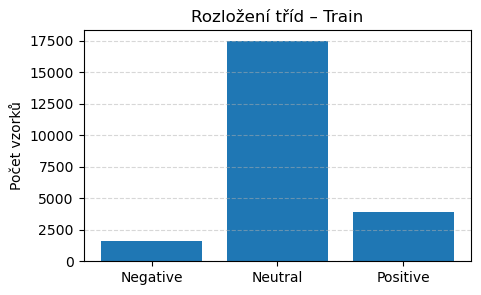


Validation - Statistika tříd:
  Negative:   206 ( 7.16%)
  Neutral :  2180 (75.77%)
  Positive:   491 (17.07%)


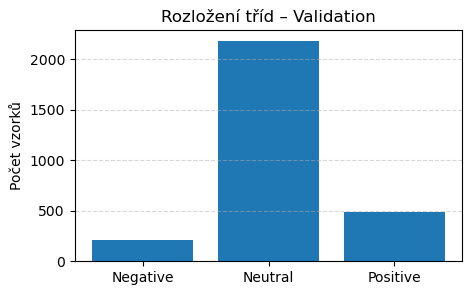


Test - Statistika tříd:
  Negative:   206 ( 7.16%)
  Neutral :  2181 (75.78%)
  Positive:   491 (17.06%)


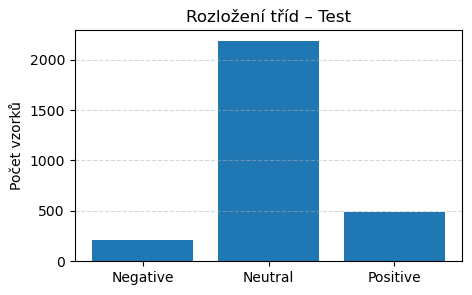


Počet vzorků v třídách: Counter({1: 17443, 2: 3927, 0: 1647})
Vypočítané (normalizované) váhy tříd: [1.9817336797714233, 0.18711893260478973, 0.831147313117981]


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_759/606053605.py:229: UserWarning: load_best_model_at_end disabled because evaluation/save strategy not compatible on this transformers version.
  warnings.warn("load_best_model_at_end disabled because evaluation/save strategy not compatible on this transformers version.")
/tmp/ipykernel_759/606053605.py:262: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(



Parametry předané do TrainingArguments:
  eval_steps: 2877
  fp16: False
  greater_is_better: True
  learning_rate: 2e-05
  load_best_model_at_end: False
  logging_dir: ./logs
  logging_steps: 100
  logging_strategy: epoch
  metric_for_best_model: f1
  num_train_epochs: 3
  output_dir: ./results
  overwrite_output_dir: True
  per_device_eval_batch_size: 8
  per_device_train_batch_size: 8
  save_strategy: epoch
  save_total_limit: 2
  seed: 42
  weight_decay: 0.01


Step,Training Loss
2878,0.519200
5756,0.360500
8634,0.259400



Model a tokenizer uloženy do: ./roberta-sentiment_v3



Výsledky na testovacích datech:
eval_loss   : 0.5598
eval_accuracy: 0.9263
eval_precision: 0.9267
eval_recall : 0.9263
eval_f1     : 0.9265
eval_runtime: 6.3627
eval_samples_per_second: 452.3260
eval_steps_per_second: 56.5800
epoch       : 3.0000


Device set to use cuda:0



Ukázka predikcí:
Text: I am so happy today! Everything went perfectly.
  Negative: 0.0011
  Neutral: 0.0274
  Positive: 0.9715

Text: I feel so sad and disappointed.
  Negative: 0.9970
  Neutral: 0.0024
  Positive: 0.0006

Text: It's just an ordinary day, nothing special happened.
  Negative: 0.0212
  Neutral: 0.9722
  Positive: 0.0067

Text: I'm frustrated and angry about this situation.
  Negative: 0.9813
  Neutral: 0.0177
  Positive: 0.0010

Text: I'm nervous about tomorrow's meeting.
  Negative: 0.3741
  Neutral: 0.6215
  Positive: 0.0044



/opt/conda/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [1]:
# ======================================================
# opravený skript kompatibilní s různými verzemi transformers
# ======================================================

from datasets import load_dataset, ClassLabel
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from collections import Counter
import inspect
import warnings

from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    pipeline
)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# ======================================================
# 1) Načtení datasetu
# ======================================================
ds = load_dataset("yuncongli/chat-sentiment-analysis", split="train")

# ======================================================
# 2) Maskování citlivých údajů
# ======================================================
def mask_sensitive(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", "<EMAIL>", text)
    text = re.sub(r"http\S+|www\.\S+", "<URL>", text)
    text = re.sub(r"\+?\d[\d\-\s]{7,}\d", "<PHONE>", text)
    text = re.sub(r"@[A-Za-z0-9_]+", "<USER>", text)
    text = re.sub(r"\b\d{4,}\b", "<NUMBER>", text)
    text = re.sub(r"(?<![.!?]\s)(?<!^)(\b[A-Z][a-z]+)", "<NAME>", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# ======================================================
# 3) Extrakce sentimentu
# ======================================================
def extract_sentiment(output_text: str):
    """
    0 -> Negative
    1 -> Neutral
    2 -> Positive
    """
    if not isinstance(output_text, str):
        return 1
    txt = output_text.lower()
    if "positive" in txt and "negative" not in txt:
        return 2
    if "negative" in txt and "positive" not in txt:
        return 0
    return 1

# ======================================================
# 4) Transformace dat
# ======================================================
def transform(example):
    text = ((example.get("instruction") or "") + " " + (example.get("input") or "")).strip()
    text = mask_sensitive(text)
    label = extract_sentiment(example.get("output", ""))
    return {"text": text, "label": label}

clean_ds = ds.map(transform)
clean_ds = clean_ds.filter(lambda x: len(x["text"]) > 5)

# ======================================================
# 5) Tokenizace
# ======================================================
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

new_features = clean_ds.features.copy()
new_features["label"] = ClassLabel(names=["Negative", "Neutral", "Positive"])
clean_ds = clean_ds.cast(new_features)
tokenized_ds = clean_ds.map(tokenize, batched=True)

# ======================================================
# 6) Rozdělení datasetu
# ======================================================
split_ds = tokenized_ds.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)
train_ds = split_ds["train"]
testval = split_ds["test"].train_test_split(test_size=0.5, stratify_by_column="label", seed=42)
valid_ds = testval["train"]
test_ds = testval["test"]

print(f"Train samples: {len(train_ds)}")
print(f"Validation samples: {len(valid_ds)}")
print(f"Test samples: {len(test_ds)}")

# ======================================================
# 7) Statistika tříd (vizualizace)
# ======================================================
def show_label_stats(dataset, name="Dataset"):
    labels = list(dataset["label"])
    df = pd.DataFrame({"label": labels})
    counts = df["label"].value_counts().sort_index()
    total = counts.sum()
    label_names = ["Negative", "Neutral", "Positive"]
    print(f"\n{name} - Statistika tříd:")
    for i, count in counts.items():
        perc = (count / total) * 100
        print(f"  {label_names[i]:<8}: {count:5d} ({perc:5.2f}%)")
    plt.figure(figsize=(5,3))
    plt.bar(label_names, counts)
    plt.title(f"Rozložení tříd – {name}")
    plt.ylabel("Počet vzorků")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()

show_label_stats(train_ds, "Train")
show_label_stats(valid_ds, "Validation")
show_label_stats(test_ds, "Test")

# ======================================================
# 8) Výpočet vah tříd
# ======================================================
def compute_class_weights(dataset):
    labels = list(dataset["label"])
    counter = Counter(labels)
    total = sum(counter.values())
    num_classes = len(counter)
    eps = 1e-6
    weights = [total / (num_classes * (counter[i] + eps)) for i in range(num_classes)]
    weights = np.array(weights, dtype=np.float32)
    weights = weights / weights.mean()   # normalizovat průměr na 1
    class_weights = torch.tensor(weights, dtype=torch.float)
    print("\nPočet vzorků v třídách:", counter)
    print("Vypočítané (normalizované) váhy tříd:", weights.tolist())
    return class_weights

class_weights = compute_class_weights(train_ds)

# ======================================================
# 9) Definice modelu a Traineru s váhami
# ======================================================
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels").to(device)
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

data_collator = DataCollatorWithPadding(tokenizer)

# ======================================================
# 10) Kompatibilní sestavení TrainingArguments
# ======================================================
# požadované "logické" nastavení
requested_args = {
    "output_dir": "./results",
    "overwrite_output_dir": True,
    "num_train_epochs": 3,
    "per_device_train_batch_size": 8,
    "per_device_eval_batch_size": 8,
    "learning_rate": 2e-5,
    "weight_decay": 0.01,
    "evaluation_strategy": "epoch",   # preferujeme "epoch" tam, kde je podporováno
    "save_strategy": "epoch",
    "load_best_model_at_end": True,
    "metric_for_best_model": "f1",
    "greater_is_better": True,
    "logging_dir": "./logs",
    "logging_strategy": "epoch",
    "save_total_limit": 2,
    "fp16": False,
    "seed": 42,
    "logging_steps": 100,
}

# zjistíme, které parametry TrainingArguments opravdu akceptuje
sig = inspect.signature(TrainingArguments.__init__)
supported = set(sig.parameters.keys())

# Připravíme slovník, který skutečně předáme do TrainingArguments
args_to_pass = {}
# základní jednoduché předání parametrů, které jsou podporovány
for k, v in requested_args.items():
    if k in supported:
        args_to_pass[k] = v

# Pokud není podporováno evaluation_strategy nebo save_strategy, použijeme eval_steps/save_steps
# (nastavíme je tak, aby vyhodnocení proběhlo ~1x na epochu)
if "evaluation_strategy" not in supported or "save_strategy" not in supported:
    # spočítáme kroky na epochu (aproximace)
    per_device = args_to_pass.get("per_device_train_batch_size", 8)
    steps_per_epoch = max(1, len(train_ds) // max(1, per_device))
    # pokud není supported eval_steps -> nastavíme eval_steps
    if "eval_steps" in supported and "evaluation_strategy" not in supported:
        args_to_pass["eval_steps"] = steps_per_epoch
    if "save_steps" in supported and "save_strategy" not in supported:
        args_to_pass["save_steps"] = steps_per_epoch

    # load_best_model_at_end vyžaduje, aby eval/save strategie byly sladěné.
    # Pokud load_best_model_at_end není podporováno, odstraníme ho. Pokud je podporováno, ale
    # nedokážeme zajistit kompatibilitu eval/save, zakážeme ho a upozorníme.
    if "load_best_model_at_end" in supported:
        # máme eval/save nastavené jako steps (nebo vůbec), musíme zajistit kompatibilitu
        # jednoduché řešení: povolíme load_best_model_at_end jen pokud máme buď:
        # - both 'evaluation_strategy' a 'save_strategy' podporovány a stejné, nebo
        # - oba 'eval_steps' a 'save_steps' nastaveny a stejné
        ok = False
        if "evaluation_strategy" in args_to_pass and "save_strategy" in args_to_pass:
            ok = args_to_pass["evaluation_strategy"] == args_to_pass["save_strategy"]
        elif "eval_steps" in args_to_pass and "save_steps" in args_to_pass:
            ok = args_to_pass["eval_steps"] == args_to_pass["save_steps"]
        if ok:
            args_to_pass["load_best_model_at_end"] = True
        else:
            # nenasázíme load_best_model_at_end, protože by vyvolalo ValueError později
            args_to_pass["load_best_model_at_end"] = False
            warnings.warn("load_best_model_at_end disabled because evaluation/save strategy not compatible on this transformers version.")
    # pokud load_best_model_at_end není v supported, nic neuděláme

# Pokud evaluation_strategy/save_strategy jsou podporovány, ujistíme se, že obě jsou nastavené stejně ("epoch")
if "evaluation_strategy" in supported and "save_strategy" in supported:
    args_to_pass["evaluation_strategy"] = "epoch"
    args_to_pass["save_strategy"] = "epoch"
    args_to_pass["load_best_model_at_end"] = True
    args_to_pass["metric_for_best_model"] = "f1"
    args_to_pass["greater_is_better"] = True

print("\nParametry předané do TrainingArguments:")
for k in sorted(args_to_pass.keys()):
    print(f"  {k}: {args_to_pass[k]}")

training_args = TrainingArguments(**args_to_pass)

# ======================================================
# 11) Metriky
# ======================================================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted", zero_division=0),
        "recall": recall_score(labels, preds, average="weighted", zero_division=0),
        "f1": f1_score(labels, preds, average="weighted", zero_division=0),
    }

# ======================================================
# 12) Inicializace Traineru a trénink
# ======================================================
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

# ======================================================
# 13) Uložení modelu + label mapy
# ======================================================
model.config.id2label = {0: "Negative", 1: "Neutral", 2: "Positive"}
model.config.label2id = {"Negative": 0, "Neutral": 1, "Positive": 2}

best_output_dir = "./roberta-sentiment_v3"
trainer.save_model(best_output_dir)
tokenizer.save_pretrained(best_output_dir)
print(f"\nModel a tokenizer uloženy do: {best_output_dir}")

# ======================================================
# 14) Vyhodnocení na testovací sadě
# ======================================================
metrics = trainer.evaluate(test_ds)
print("\nVýsledky na testovacích datech:")
for k, v in metrics.items():
    print(f"{k:<12}: {v:.4f}")

# ======================================================
# 15) Inference příklad
# ======================================================
device_id = 0 if torch.cuda.is_available() else -1
pipe = pipeline("text-classification", model=best_output_dir, tokenizer=best_output_dir, return_all_scores=True, device=device_id)

samples = [
    "I am so happy today! Everything went perfectly.",
    "I feel so sad and disappointed.",
    "It's just an ordinary day, nothing special happened.",
    "I'm frustrated and angry about this situation.",
    "I'm nervous about tomorrow's meeting."
]

print("\nUkázka predikcí:")
for t in samples:
    out = pipe(t)[0]
    print("Text:", t)
    for cls in out:
        print(f"  {cls['label']}: {cls['score']:.4f}")
    print()


In [7]:
pip install -U transformers[torch]


Note: you may need to restart the kernel to use updated packages.


Train samples: 23017
Validation samples: 2877
Test samples: 2878

Train - Statistika tříd:
  Negative:  1647 ( 7.16%)
  Neutral : 17443 (75.78%)
  Positive:  3927 (17.06%)


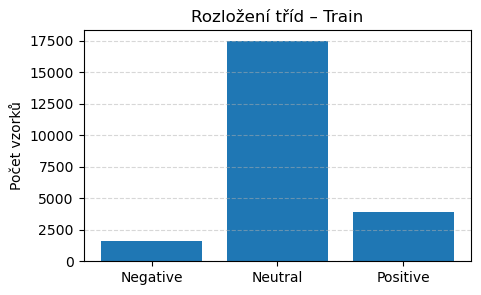


Validation - Statistika tříd:
  Negative:   206 ( 7.16%)
  Neutral :  2180 (75.77%)
  Positive:   491 (17.07%)


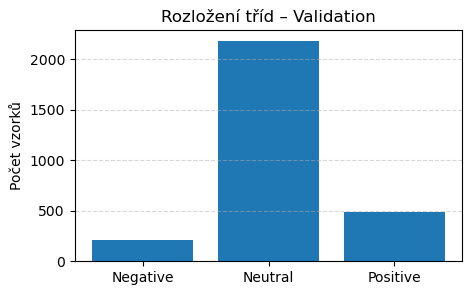


Test - Statistika tříd:
  Negative:   206 ( 7.16%)
  Neutral :  2181 (75.78%)
  Positive:   491 (17.06%)


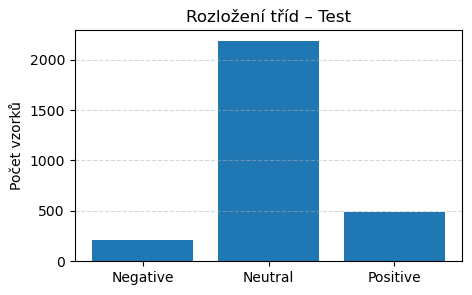


Počet vzorků v třídách: Counter({1: 17443, 2: 3927, 0: 1647})
Vypočítané (normalizované) váhy tříd: [1.9817336797714233, 0.18711893260478973, 0.831147313117981]


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_759/509058124.py:221: UserWarning: load_best_model_at_end disabled because evaluation/save strategy not compatible.
  warnings.warn("load_best_model_at_end disabled because evaluation/save strategy not compatible.")
/tmp/ipykernel_759/509058124.py:253: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(



Parametry předané do TrainingArguments:
  eval_steps: 2877
  fp16: False
  greater_is_better: True
  learning_rate: 2e-05
  load_best_model_at_end: False
  logging_dir: ./logs
  logging_steps: 100
  logging_strategy: epoch
  metric_for_best_model: f1
  num_train_epochs: 3
  output_dir: ./results
  overwrite_output_dir: True
  per_device_eval_batch_size: 8
  per_device_train_batch_size: 8
  save_strategy: epoch
  save_total_limit: 2
  seed: 42
  weight_decay: 0.01


Step,Training Loss
2878,0.500100
5756,0.359800
8634,0.263500



Model a tokenizer uloženy do: ./roberta-sentiment_dataset1



Výsledky na testovacích datech:
eval_loss   : 0.5240
eval_accuracy: 0.9277
eval_precision: 0.9286
eval_recall : 0.9277
eval_f1     : 0.9281
eval_runtime: 6.0860
eval_samples_per_second: 472.8890
eval_steps_per_second: 59.1520
epoch       : 3.0000


Device set to use cuda:0



Ukázka predikcí:
Text: I am so happy today! Everything went perfectly.
  Negative: 0.0005
  Neutral: 0.0039
  Positive: 0.9956

Text: I feel so sad and disappointed.
  Negative: 0.9946
  Neutral: 0.0049
  Positive: 0.0005

Text: It's just an ordinary day, nothing special happened.
  Negative: 0.0045
  Neutral: 0.9931
  Positive: 0.0024

Text: I'm frustrated and angry about this situation.
  Negative: 0.0524
  Neutral: 0.9457
  Positive: 0.0019

Text: I'm nervous about tomorrow's meeting.
  Negative: 0.4178
  Neutral: 0.5802
  Positive: 0.0020



/opt/conda/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [2]:
from datasets import load_dataset, ClassLabel
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from collections import Counter
import inspect
import warnings   # změna: přidán kvůli upozornění, pokud některé parametry nejsou podporovány

from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    pipeline
)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# ======================================================
# 1) Načtení datasetu
# ======================================================
ds = load_dataset("yuncongli/chat-sentiment-analysis", split="train")

# ======================================================
# 2) Maskování citlivých údajů
# ======================================================
def mask_sensitive(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", "<EMAIL>", text)
    text = re.sub(r"http\S+|www\.\S+", "<URL>", text)
    text = re.sub(r"\+?\d[\d\-\s]{7,}\d", "<PHONE>", text)
    text = re.sub(r"@[A-Za-z0-9_]+", "<USER>", text)
    text = re.sub(r"\b\d{4,}\b", "<NUMBER>", text)
    text = re.sub(r"(?<![.!?]\s)(?<!^)(\b[A-Z][a-z]+)", "<NAME>", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# ======================================================
# 3) Extrakce sentimentu
# ======================================================
def extract_sentiment(output_text: str):
    """
    0 -> Negative
    1 -> Neutral
    2 -> Positive
    """
    if not isinstance(output_text, str):
        return 1
    txt = output_text.lower()
    if "positive" in txt and "negative" not in txt:
        return 2
    if "negative" in txt and "positive" not in txt:
        return 0
    return 1

# ======================================================
# 4) Transformace dat
# ======================================================
def transform(example):
    text = ((example.get("instruction") or "") + " " + (example.get("input") or "")).strip()
    text = mask_sensitive(text)
    label = extract_sentiment(example.get("output", ""))
    return {"text": text, "label": label}

clean_ds = ds.map(transform)
clean_ds = clean_ds.filter(lambda x: len(x["text"]) > 5)

# ======================================================
# 5) Tokenizace
# ======================================================
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

new_features = clean_ds.features.copy()
new_features["label"] = ClassLabel(names=["Negative", "Neutral", "Positive"])
clean_ds = clean_ds.cast(new_features)
tokenized_ds = clean_ds.map(tokenize, batched=True)

# ======================================================
# 6) Rozdělení datasetu
# ======================================================
split_ds = tokenized_ds.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)
train_ds = split_ds["train"]
testval = split_ds["test"].train_test_split(test_size=0.5, stratify_by_column="label", seed=42)
valid_ds = testval["train"]
test_ds = testval["test"]

print(f"Train samples: {len(train_ds)}")
print(f"Validation samples: {len(valid_ds)}")
print(f"Test samples: {len(test_ds)}")

# ======================================================
# 7) Statistika tříd
# ======================================================
def show_label_stats(dataset, name="Dataset"):
    labels = list(dataset["label"])
    df = pd.DataFrame({"label": labels})
    counts = df["label"].value_counts().sort_index()
    total = counts.sum()
    label_names = ["Negative", "Neutral", "Positive"]
    print(f"\n{name} - Statistika tříd:")
    for i, count in counts.items():
        perc = (count / total) * 100
        print(f"  {label_names[i]:<8}: {count:5d} ({perc:5.2f}%)")
    plt.figure(figsize=(5,3))
    plt.bar(label_names, counts)
    plt.title(f"Rozložení tříd – {name}")
    plt.ylabel("Počet vzorků")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()

show_label_stats(train_ds, "Train")
show_label_stats(valid_ds, "Validation")
show_label_stats(test_ds, "Test")

# ======================================================
# 8) Výpočet vah tříd
# ======================================================
def compute_class_weights(dataset):
    labels = list(dataset["label"])
    counter = Counter(labels)
    total = sum(counter.values())
    num_classes = len(counter)
    eps = 1e-6
    weights = [total / (num_classes * (counter[i] + eps)) for i in range(num_classes)]
    weights = np.array(weights, dtype=np.float32)
    weights = weights / weights.mean()   # normalizovat průměr na 1
    class_weights = torch.tensor(weights, dtype=torch.float)
    print("\nPočet vzorků v třídách:", counter)
    print("Vypočítané (normalizované) váhy tříd:", weights.tolist())
    return class_weights

class_weights = compute_class_weights(train_ds)

# ======================================================
# 9) Definice modelu a Traineru s váhami
# ======================================================
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels").to(device)
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # změna: CrossEntropyLoss s váhami podle distribuce tříd
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

data_collator = DataCollatorWithPadding(tokenizer)

# ======================================================
# 10) Kompatibilní sestavení TrainingArguments
# ======================================================
# změna: nová robustní logika, která zjistí, jaké argumenty TrainingArguments podporuje
#        a podle toho automaticky upraví nebo nahradí parametry (např. eval/save_strategy)
# === Training configuration (based on Hugging Face best practices) ===
# Zdroj logiky:
# - https://huggingface.co/docs/transformers/main_classes/trainer#trainingarguments
# - HF example: run_glue.py (text classification)
# - Paper: "RoBERTa: A Robustly Optimized BERT Pretraining Approach", Liu et al. (2019)
requested_args = {
    "output_dir": "./results",             # Výstupní složka pro modely a logy
    "overwrite_output_dir": True,          # Přepíše staré výstupy při novém běhu
    "num_train_epochs": 3,                 # Počet epoch (doporučeno HF)
    "per_device_train_batch_size": 8,      # Batch size pro trénink
    "per_device_eval_batch_size": 8,       # Batch size pro evaluaci
    "learning_rate": 2e-5,                 # Doporučený LR pro BERT/RoBERTa
    "weight_decay": 0.01,                  # Regularizace vah
    "evaluation_strategy": "epoch",        # Evaluace po každé epoše
    "save_strategy": "epoch",              # Uložení po každé epoše
    "load_best_model_at_end": True,        # Načti nejlepší model po tréninku
    "metric_for_best_model": "f1",         # Kritérium pro výběr nejlepšího modelu
    "greater_is_better": True,             # Vyšší F1 = lepší model
    "logging_dir": "./logs",               # Složka pro logy (TensorBoard)
    "logging_strategy": "epoch",           # Logování po epochách
    "save_total_limit": 2,                 # Jen 2 nejnovější checkpointy
    "fp16": False,                         # 16bit vypnuto (pro CPU)
    "seed": 42,                            # Reprodukovatelnost
    "logging_steps": 100,                  # Log každých 100 batchů
}


# změna: detekce dostupných parametrů ve verzi transformers
sig = inspect.signature(TrainingArguments.__init__)
supported = set(sig.parameters.keys())

# změna: vytvoření args_to_pass, který obsahuje jen ty parametry, které verze podporuje
args_to_pass = {}
for k, v in requested_args.items():
    if k in supported:
        args_to_pass[k] = v

# změna: fallback – pokud evaluation/save_strategy nejsou podporovány, dopočítáme eval_steps/save_steps
if "evaluation_strategy" not in supported or "save_strategy" not in supported:
    per_device = args_to_pass.get("per_device_train_batch_size", 8)
    steps_per_epoch = max(1, len(train_ds) // max(1, per_device))
    if "eval_steps" in supported and "evaluation_strategy" not in supported:
        args_to_pass["eval_steps"] = steps_per_epoch
    if "save_steps" in supported and "save_strategy" not in supported:
        args_to_pass["save_steps"] = steps_per_epoch

    # změna: load_best_model_at_end se aktivuje jen pokud strategie ladí
    if "load_best_model_at_end" in supported:
        ok = False
        if "evaluation_strategy" in args_to_pass and "save_strategy" in args_to_pass:
            ok = args_to_pass["evaluation_strategy"] == args_to_pass["save_strategy"]
        elif "eval_steps" in args_to_pass and "save_steps" in args_to_pass:
            ok = args_to_pass["eval_steps"] == args_to_pass["save_steps"]
        if ok:
            args_to_pass["load_best_model_at_end"] = True
        else:
            args_to_pass["load_best_model_at_end"] = False
            warnings.warn("load_best_model_at_end disabled because evaluation/save strategy not compatible.")

# změna: pokud obě strategie jsou podporovány, sjednotíme je na 'epoch'
if "evaluation_strategy" in supported and "save_strategy" in supported:
    args_to_pass["evaluation_strategy"] = "epoch"
    args_to_pass["save_strategy"] = "epoch"
    args_to_pass["load_best_model_at_end"] = True
    args_to_pass["metric_for_best_model"] = "f1"
    args_to_pass["greater_is_better"] = True

print("\nParametry předané do TrainingArguments:")
for k in sorted(args_to_pass.keys()):
    print(f"  {k}: {args_to_pass[k]}")

training_args = TrainingArguments(**args_to_pass)

# ======================================================
# 11) Metriky
# ======================================================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted", zero_division=0),
        "recall": recall_score(labels, preds, average="weighted", zero_division=0),
        "f1": f1_score(labels, preds, average="weighted", zero_division=0),
    }

# ======================================================
# 12) Inicializace Traineru a trénink
# ======================================================
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

# ======================================================
# 13) Uložení modelu + label mapy
# ======================================================
model.config.id2label = {0: "Negative", 1: "Neutral", 2: "Positive"}
model.config.label2id = {"Negative": 0, "Neutral": 1, "Positive": 2}

best_output_dir = "./roberta-sentiment_dataset1"
trainer.save_model(best_output_dir)
tokenizer.save_pretrained(best_output_dir)
print(f"\nModel a tokenizer uloženy do: {best_output_dir}")

# ======================================================
# 14) Vyhodnocení na testovací sadě
# ======================================================
metrics = trainer.evaluate(test_ds)
print("\nVýsledky na testovacích datech:")
for k, v in metrics.items():
    print(f"{k:<12}: {v:.4f}")

# ======================================================
# 15) Inference příklad
# ======================================================
device_id = 0 if torch.cuda.is_available() else -1
pipe = pipeline("text-classification", model=best_output_dir, tokenizer=best_output_dir, return_all_scores=True, device=device_id)

samples = [
    "I am so happy today! Everything went perfectly.",
    "I feel so sad and disappointed.",
    "It's just an ordinary day, nothing special happened.",
    "I'm frustrated and angry about this situation.",
    "I'm nervous about tomorrow's meeting."
]

print("\nUkázka predikcí:")
for t in samples:
    out = pipe(t)[0]
    print("Text:", t)
    for cls in out:
        print(f"  {cls['label']}: {cls['score']:.4f}")
    print()


In [3]:
# Pouziti puvodniho skriptu, natrenovaneho na spatnem vyvazovani trid
from datasets import Dataset, ClassLabel
import pandas as pd
import re
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import torch
import torch.nn as nn
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

#1. Načtení CSV datasetu 
df2 = pd.read_csv("empathetic_dialogues.csv")
df2['text'] = df2['Situation'].fillna('') + " " + df2['empathetic_dialogues'].fillna('')

# Mapování emocí na integer labely
emotion2label = {
    # Negative emotions
    "sad": 0, "angry": 0, "afraid": 0, "anxious": 0, "ashamed": 0, "disgusted": 0,
    "embarrassed": 0, "guilty": 0, "jealous": 0, "lonely": 0, "disappointed": 0,
    "terrified": 0, "nostalgic": 0, "devastated": 0, "annoyed": 0,
    
    # Neutral emotions
    "neutral": 1, "surprised": 1, "confused": 1, "anticipating": 1, "apprehensive": 1,
    "hopeful": 1, "caring": 1, "sentimental": 1,
    
    # Positive emotions
    "happy": 2, "excited": 2, "content": 2, "grateful": 2, "proud": 2, "impressed": 2,
    "joyful": 2, "trusting": 2, "prepared": 2, "confident": 2
}

df2['label'] = df2['emotion'].map(emotion2label).fillna(1).astype(int)

ds2 = Dataset.from_pandas(df2[['text','label']])

# 2. Maskování citlivých údajů 
def mask_sensitive(text: str) -> str:
    if not isinstance(text, str): return ""
    text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", "<EMAIL>", text)
    text = re.sub(r"http\S+|www\.\S+", "<URL>", text)
    text = re.sub(r"\+?\d[\d\-\s]{7,}\d", "<PHONE>", text)
    text = re.sub(r"@[A-Za-z0-9_]+", "<USER>", text)
    text = re.sub(r"\b\d{4,}\b", "<NUMBER>", text)
    text = re.sub(r"(?<![.!?]\s)(?<!^)(\b[A-Z][a-z]+)", "<NAME>", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

ds2_clean = ds2.map(lambda x: {'text': mask_sensitive(x['text']), 'label': x['label']})
ds2_clean = ds2_clean.filter(lambda x: len(x['text'])>5)

# 3. Tokenizace 
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

# Převod labelu na ClassLabel
new_features = ds2_clean.features.copy()
new_features['label'] = ClassLabel(names=["Negative","Neutral","Positive"])
ds2_clean = ds2_clean.cast(new_features)
tokenized_ds2 = ds2_clean.map(tokenize, batched=True)

# 4. Rozdělení datasetu 
split_ds2 = tokenized_ds2.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)
train_ds2 = split_ds2['train']
testval_ds2 = split_ds2['test'].train_test_split(test_size=0.5, stratify_by_column="label", seed=42)
valid_ds2 = testval_ds2['train']
test_ds2 = testval_ds2['test']

print(f"Train2: {len(train_ds2)}, Validation2: {len(valid_ds2)}, Test2: {len(test_ds2)}")

# 5. Výpočet vah tříd s kontrolou chybějících tříd 
def compute_class_weights(dataset, num_labels=3):
    counter = Counter(dataset['label'])
    total = sum(counter.values())
    weights = []
    for i in range(num_labels):
        if i in counter:
            weights.append(total / (num_labels * counter[i]))
        else:
            weights.append(0.0)
    return torch.tensor(weights, dtype=torch.float)

class_weights2 = compute_class_weights(train_ds2)
print("Class weights for second dataset:", class_weights2)

# 6. Data collator 
data_collator = DataCollatorWithPadding(tokenizer)

# 7. Load previously trained model 
model = RobertaForSequenceClassification.from_pretrained("./roberta-sentiment_dataset1", num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 8. Custom Weighted Trainer 
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels").to(device)
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights2.to(device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# 9. TrainingArguments 
training_args2 = TrainingArguments(
    output_dir="./roberta-sentiment_dataset2",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs_empathetic",
    logging_steps=100,
)

# 10. Inicializace Traineru 
trainer2 = WeightedTrainer(
    model=model,
    args=training_args2,
    train_dataset=train_ds2,
    eval_dataset=valid_ds2,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred[1], np.argmax(eval_pred[0], axis=-1)),
        "precision": precision_score(eval_pred[1], np.argmax(eval_pred[0], axis=-1), average="weighted"),
        "recall": recall_score(eval_pred[1], np.argmax(eval_pred[0], axis=-1), average="weighted"),
        "f1": f1_score(eval_pred[1], np.argmax(eval_pred[0], axis=-1), average="weighted"),
    }
)

# 11. Continued fine-tuning 
trainer2.train()
trainer2.save_model("./roberta-sentiment_dataset2")
tokenizer.save_pretrained("./roberta-sentiment_dataset2")


# 12. Vyhodnocení na testovacích datech 
metrics2 = trainer2.evaluate(test_ds2)
print("Výsledky na testovacích datech (empathetic-dialogues):")
for k,v in metrics2.items():
    print(f"{k:<12}: {v:.4f}")


Map:   0%|          | 0/64636 [00:00<?, ? examples/s]

Filter:   0%|          | 0/64636 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/64636 [00:00<?, ? examples/s]

Map:   0%|          | 0/64636 [00:00<?, ? examples/s]

Train2: 51708, Validation2: 6464, Test2: 6464
Class weights for second dataset: tensor([0.7077, 1.3636, 1.1715])


/tmp/ipykernel_759/1957570035.py:116: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer2 = WeightedTrainer(


Step,Training Loss
100,0.963500
200,0.745300
300,0.673200
400,0.656500
500,0.600700
600,0.592500
700,0.579400
800,0.579400
900,0.512900
1000,0.546900


Výsledky na testovacích datech (empathetic-dialogues):
eval_loss   : 0.2152
eval_accuracy: 0.9559
eval_precision: 0.9559
eval_recall : 0.9559
eval_f1     : 0.9559
eval_runtime: 12.3577
eval_samples_per_second: 523.0740
eval_steps_per_second: 32.6920
epoch       : 3.0000


In [4]:
from transformers import pipeline, RobertaTokenizer, RobertaForSequenceClassification
import torch

# Načtení modelu a tokenizeru
model_path = "./roberta-sentiment_dataset2"
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)
device = 0 if torch.cuda.is_available() else -1

sentiment_pipe = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,   # pro zobrazení všech tří tříd
    device=device
)

# Test na několika větách
sample_texts = [
    "I am so happy today! Everything went perfectly.",
    "I feel so sad and disappointed.",
    "It's just an ordinary day, nothing special happened.",
    "I'm frustrated and angry about this situation.",
    "I'm nervous about tomorrow's meeting."
]

print("\n=== SAMPLE INFERENCE ===\n")
for text in sample_texts:
    scores = sentiment_pipe(text)[0]
    print(f"Text: {text}")
    for score in scores:
        label = score['label']
        value = score['score']
        # přejmenování labelů podle ClassLabel
        if label == "LABEL_0":
            label_name = "Negative"
        elif label == "LABEL_1":
            label_name = "Neutral"
        else:
            label_name = "Positive"
        print(f"  {label_name}: {value:.4f}")
    print()


Device set to use cuda:0



=== SAMPLE INFERENCE ===

Text: I am so happy today! Everything went perfectly.
  Positive: 0.0001
  Positive: 0.0009
  Positive: 0.9990

Text: I feel so sad and disappointed.
  Positive: 0.9988
  Positive: 0.0011
  Positive: 0.0001

Text: It's just an ordinary day, nothing special happened.
  Positive: 0.0026
  Positive: 0.0167
  Positive: 0.9807

Text: I'm frustrated and angry about this situation.
  Positive: 0.9988
  Positive: 0.0011
  Positive: 0.0001

Text: I'm nervous about tomorrow's meeting.
  Positive: 0.9945
  Positive: 0.0053
  Positive: 0.0002



/opt/conda/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [5]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch
import numpy as np

# 1️⃣ Načtení modelu a tokenizeru
model_path = "./roberta-sentiment_dataset2"
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# 2️⃣ Vybereme několik testovacích vzorků
sample_ds = test_ds2.select(range(min(10, len(test_ds2))))  # prvních 10 vzorků
sample_texts = [x["text"] for x in sample_ds]
true_labels = [x["label"] for x in sample_ds]

# 3️⃣ Inference
print("=== QUICK SAMPLE INFERENCE ===\n")
for text, true_label in zip(sample_texts, true_labels):
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
    inputs = {k:v.to(device) for k,v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_label = torch.argmax(logits, dim=-1).item()
    
    # Převod labelů na názvy
    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    print(f"Text: {text}")
    print(f"  True label : {label_map[true_label]}")
    print(f"  Pred label : {label_map[pred_label]}\n")


=== QUICK SAMPLE INFERENCE ===

Text: My friends dog ran away. we looked for him all day but we couldnt find him. I was pretty upset about it <NAME> :<NAME> was really nice of you. Did you find it? Agent :
  True label : Negative
  Pred label : Negative

Text: My flight has been delayed 7 hours due to weather, I'm mad. Customer :<NAME> to weather. <NAME> did I pick the wrong day to travel. Agent :
  True label : Negative
  Pred label : Negative

Text: I wanted to do something to show my <NAME> some love so I made her a dinner of all of her favorites. I made extras for the freezer so she would be able to enjoy them again. Customer :aww that's so sweet of you to do, did she enjoy that? Agent :
  True label : Neutral
  Pred label : Neutral

Text: I was looking at some of the old photos I have of my grandpa. He passed away, so I've been reminiscing over him. Customer :I'm so sorry. I know that must be very difficult for you. It's nice that you have pictures to look at and remember old time

In [6]:
from transformers import pipeline, RobertaTokenizer, RobertaForSequenceClassification
import torch

# Načtení modelu a tokenizeru
model_path = "./roberta-sentiment_dataset2"
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)
device = 0 if torch.cuda.is_available() else -1

sentiment_pipe = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,   # pro zobrazení všech tří tříd
    device=device
)

# Test na několika větách
sample_texts = [
    "I am so happy today! Everything went perfectly.",
    "I feel so sad and disappointed.",
    "It's just an ordinary day, nothing special happened.",
    "I'm frustrated and angry about this situation.",
    "I'm nervous about tomorrow's meeting."
]

print("\n=== SAMPLE INFERENCE ===\n")
for text in sample_texts:
    scores = sentiment_pipe(text)[0]
    print(f"Text: {text}")
    for score in scores:
        label = score['label']
        value = score['score']
        # přejmenování labelů podle ClassLabel
        if label == "LABEL_0":
            label_name = "Negative"
        elif label == "LABEL_1":
            label_name = "Neutral"
        else:
            label_name = "Positive"
        print(f"  {label_name}: {value:.4f}")
    print()


Device set to use cuda:0



=== SAMPLE INFERENCE ===

Text: I am so happy today! Everything went perfectly.
  Positive: 0.0001
  Positive: 0.0009
  Positive: 0.9990

Text: I feel so sad and disappointed.
  Positive: 0.9988
  Positive: 0.0011
  Positive: 0.0001

Text: It's just an ordinary day, nothing special happened.
  Positive: 0.0026
  Positive: 0.0167
  Positive: 0.9807

Text: I'm frustrated and angry about this situation.
  Positive: 0.9988
  Positive: 0.0011
  Positive: 0.0001

Text: I'm nervous about tomorrow's meeting.
  Positive: 0.9945
  Positive: 0.0053
  Positive: 0.0002



Loading model and tokenizer...


Device set to use cuda:0
/opt/conda/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(



=== SAMPLE INFERENCE ===

Text: I am so happy today! Everything went perfectly.
  Positive: 0.9990
  Neutral: 0.0009
  Negative: 0.0001

Text: I feel so sad and disappointed.
  Negative: 0.9988
  Neutral: 0.0011
  Positive: 0.0001

Text: It's just an ordinary day, nothing special happened.
  Positive: 0.9807
  Neutral: 0.0167
  Negative: 0.0026

Text: I'm frustrated and angry about this situation.
  Negative: 0.9988
  Neutral: 0.0011
  Positive: 0.0001

Text: I'm nervous about tomorrow's meeting.
  Negative: 0.9945
  Neutral: 0.0053
  Positive: 0.0002

Text: It is normal situation.
  Positive: 0.9710
  Neutral: 0.0206
  Negative: 0.0083

=== EVALUATION ON TEST DATASET ===


Accuracy : 0.9559
Precision: 0.9559
Recall   : 0.9559
F1 Score : 0.9559


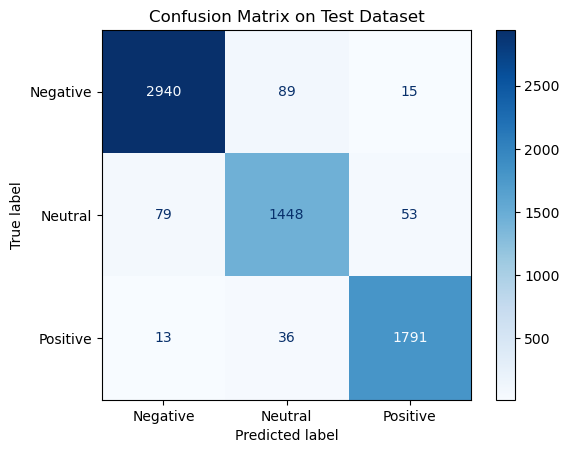


Saving detailed results to 'model_predictions.csv' ...
File saved: model_predictions.csv


In [8]:
#test na datasetu
from transformers import pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# 1️ Načtení modelu a tokenizeru
model_path = "./roberta-sentiment_dataset2"
tokenizer_name = "roberta-base"

print("Loading model and tokenizer...")
sentiment_pipe = pipeline(
    "text-classification",
    model=model_path,
    tokenizer=tokenizer_name,
    return_all_scores=True,
    device=0 if torch.cuda.is_available() else -1
)

# 2️ Test inference – kontrola na několika vlastních větách
sample_texts = [
    "I am so happy today! Everything went perfectly.",
    "I feel so sad and disappointed.",
    "It's just an ordinary day, nothing special happened.",
    "I'm frustrated and angry about this situation.",
    "I'm nervous about tomorrow's meeting.",
    "It is normal situation."
]

print("\n=== SAMPLE INFERENCE ===")
for text in sample_texts:
    preds = sentiment_pipe(text)[0]
    preds_sorted = sorted(preds, key=lambda x: x['score'], reverse=True)
    print(f"\nText: {text}")
    for p in preds_sorted:
        print(f"  {p['label']}: {p['score']:.4f}")

# 3️ Vyhodnocení na testovacím datasetu (pokud máš test_ds2 z paměti)
try:
    print("\n=== EVALUATION ON TEST DATASET ===")
    predictions = trainer2.predict(test_ds2)
    y_true = predictions.label_ids
    y_pred = np.argmax(predictions.predictions, axis=-1)

    # Metriky
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")

    # 4️ Matice záměn
    labels = ["Negative", "Neutral", "Positive"]
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix on Test Dataset")
    plt.show()

    # 5️ Uložení výsledků do CSV
    print("\nSaving detailed results to 'model_predictions.csv' ...")
    df_results = pd.DataFrame({
        "text": test_ds2["text"],
        "true_label": [labels[i] for i in y_true],
        "pred_label": [labels[i] for i in y_pred]
    })
    df_results.to_csv("model_predictions.csv", index=False)
    print("File saved: model_predictions.csv")

except NameError:
    print("\n Variable 'trainer2' or 'test_ds2' not found. Please make sure to load your dataset and trainer first.")


Loading model and tokenizer...


Device set to use cuda:0
/opt/conda/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(



=== SAMPLE INFERENCE ===

Text: I am so happy today! Everything went perfectly.
  Positive: 0.9956
  Neutral: 0.0039
  Negative: 0.0005

Text: I feel so sad and disappointed.
  Negative: 0.9946
  Neutral: 0.0049
  Positive: 0.0005

Text: It's just an ordinary day, nothing special happened.
  Neutral: 0.9931
  Negative: 0.0045
  Positive: 0.0024

Text: I'm frustrated and angry about this situation.
  Neutral: 0.9457
  Negative: 0.0524
  Positive: 0.0019

Text: I'm nervous about tomorrow's meeting.
  Neutral: 0.5802
  Negative: 0.4178
  Positive: 0.0020

Text: It is normal situation.
  Neutral: 0.9587
  Positive: 0.0323
  Negative: 0.0090

=== EVALUATION ON TEST DATASET ===


Accuracy : 0.9559
Precision: 0.9559
Recall   : 0.9559
F1 Score : 0.9559


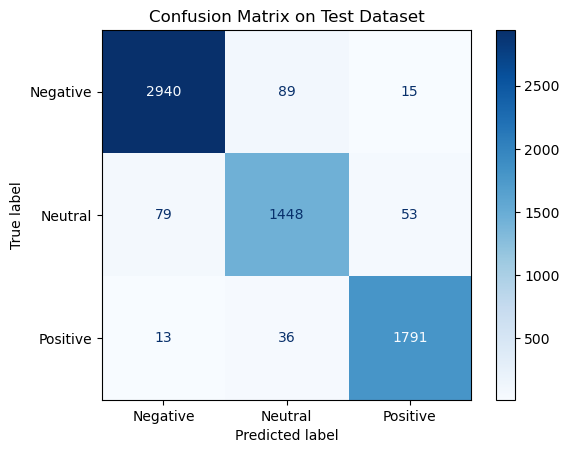


Saving detailed results to 'model_predictions.csv' ...
File saved: model_predictions.csv


In [9]:
#test na datasetu
from transformers import pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# 1️ Načtení modelu a tokenizeru
model_path = "./roberta-sentiment_dataset1"
tokenizer_name = "roberta-base"

print("Loading model and tokenizer...")
sentiment_pipe = pipeline(
    "text-classification",
    model=model_path,
    tokenizer=tokenizer_name,
    return_all_scores=True,
    device=0 if torch.cuda.is_available() else -1
)

# 2️ Test inference – kontrola na několika vlastních větách
sample_texts = [
    "I am so happy today! Everything went perfectly.",
    "I feel so sad and disappointed.",
    "It's just an ordinary day, nothing special happened.",
    "I'm frustrated and angry about this situation.",
    "I'm nervous about tomorrow's meeting.",
    "It is normal situation."
]

print("\n=== SAMPLE INFERENCE ===")
for text in sample_texts:
    preds = sentiment_pipe(text)[0]
    preds_sorted = sorted(preds, key=lambda x: x['score'], reverse=True)
    print(f"\nText: {text}")
    for p in preds_sorted:
        print(f"  {p['label']}: {p['score']:.4f}")

# 3️ Vyhodnocení na testovacím datasetu (pokud máš test_ds2 z paměti)
try:
    print("\n=== EVALUATION ON TEST DATASET ===")
    predictions = trainer2.predict(test_ds2)
    y_true = predictions.label_ids
    y_pred = np.argmax(predictions.predictions, axis=-1)

    # Metriky
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")

    # 4️ Matice záměn
    labels = ["Negative", "Neutral", "Positive"]
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix on Test Dataset")
    plt.show()

    # 5️ Uložení výsledků do CSV
    print("\nSaving detailed results to 'model_predictions.csv' ...")
    df_results = pd.DataFrame({
        "text": test_ds2["text"],
        "true_label": [labels[i] for i in y_true],
        "pred_label": [labels[i] for i in y_pred]
    })
    df_results.to_csv("model_predictions_1.csv", index=False)
    print("File saved: model_predictions.csv")

except NameError:
    print("\n Variable 'trainer2' or 'test_ds2' not found. Please make sure to load your dataset and trainer first.")
